In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sklearn, os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, BatchNormalization

/home/yloukachev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}

ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [3]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])
df = merged_dataset.to_dataframe().reset_index()

df['A'], df['B'], df['C'] = np.sin(df['ylat']), np.sin(df['xlon'])*np.cos(df['ylat']), -np.cos(df['xlon'])*np.cos(df['ylat'])

df.dropna(subset=['pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
shift_param = int(df.shape[0]/df['time'].nunique())

df.drop(columns=['xlon', 'ylat', 'time', 'TLONG', 'TLAT'], inplace=True)

print('We shift the dataset by %i rows to incorporate the sequential nature of the data.' %shift_param)
print('The dataset contains %i years worth of data.' %((df.shape[0]/shift_param)/12))

We shift the dataset by 41070 rows to incorporate the sequential nature of the data.
The dataset contains 35 years worth of data.


In [4]:
scaler = StandardScaler()
# not scaling the data for now...
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(df)

# shift the time series down by one timestep
scaled_df.columns = df.columns
scaled_df['pCO2(t)'] = scaled_df['pCO2']
scaled_df = pd.concat([scaled_df[scaled_df.columns[:-2]].shift(-shift_param), scaled_df['pCO2(t)']], axis=1)

# remove null values generated by shifting the time series
scaled_df.dropna(how='any', inplace=True)

In [5]:
scaled_df.head()

,pCO2,XCO2,SST,SSS,MLD,Chl,A,B,pCO2(t)
20,259.943180,340.96225,-1.643371,33.400482,22.005390,0.064728,-0.375524,0.444338,256.390077
21,264.257161,340.96225,-1.661482,33.388058,23.062262,0.079743,0.576990,0.391571,262.338616
22,269.302537,340.96225,-1.593351,33.278996,22.597095,0.077933,0.999021,-0.021204,261.956626
23,275.715089,340.96225,-1.370293,33.126888,22.107952,0.069886,0.502557,-0.414484,262.739347
24,285.947764,340.96225,-0.831875,33.111485,23.515684,0.060309,-0.455956,-0.426690,266.288585


In [6]:
values = scaled_df.values
n_train_months = shift_param * 12 * 30 # training on 30 years and evaluating on five years

train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [7]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14785200, 1, 8) (14785200,) (2464200, 1, 8) (2464200,)


In [16]:
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1024, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop',  metrics=['mse'])

history = model.fit(train_X, train_y, epochs=11, batch_size=shift_param, validation_data=(test_X, test_y), shuffle=False)

Train on 14785200 samples, validate on 2464200 samples
Epoch 1/11
14785200/14785200 [==============================] - 107s 7us/step - loss: 37.0554 - mean_squared_error: 3148.0367 - val_loss: 22.0377 - val_mean_squared_error: 845.2593
Epoch 2/11
14785200/14785200 [==============================] - 105s 7us/step - loss: 28.9660 - mean_squared_error: 1273.2016 - val_loss: 37.7020 - val_mean_squared_error: 1898.7221
Epoch 3/11
14785200/14785200 [==============================] - 104s 7us/step - loss: 27.1693 - mean_squared_error: 1107.0043 - val_loss: 18.9274 - val_mean_squared_error: 643.0822
Epoch 4/11
14785200/14785200 [==============================] - 105s 7us/step - loss: 25.6456 - mean_squared_error: 1007.8035 - val_loss: 34.5209 - val_mean_squared_error: 1560.7523
Epoch 5/11
14785200/14785200 [==============================] - 105s 7us/step - loss: 24.2950 - mean_squared_error: 891.8169 - val_loss: 16.2409 - val_mean_squared_error: 489.3710
Epoch 6/11
14785200/14785200 [=========

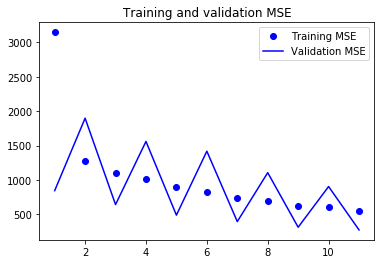

In [18]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

## Sequential Models - LSTM

The LSTM model below does not use a lagged dependency when processing sequentially processing the data.

In [4]:
df['pCO2'] = df.pop('pCO2')

df.head()

,XCO2,SST,SSS,MLD,Chl,A,B,C,pCO2
20,340.848541,-1.552322,33.641834,12.729663,1.128493,-0.375524,0.444338,-0.813355,256.390077
21,340.848541,-1.626047,33.667816,19.951666,0.900315,0.576990,0.391571,-0.716767,262.338616
22,340.848541,-1.607591,33.572289,19.510101,0.635458,0.999021,-0.021204,0.038813,261.956626
23,340.848541,-1.496069,33.424641,20.714338,0.420227,0.502557,-0.414484,0.758709,262.739347
24,340.848541,-1.207762,33.317802,20.579535,0.380468,-0.455956,-0.426690,0.781051,266.288585


In [5]:
values = df.values
n_train_months = shift_param * 12 * 30 # training on 30 years and evaluating on five years
scaler = MinMaxScaler(feature_range=(0, 1))

train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# train_X, text_X = scaler.fit_transform(train_X), scaler.fit_transform(test_X)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14785200, 1, 8) (14785200,) (2505270, 1, 8) (2505270,)


In [8]:
# baseline LSTM model

model = Sequential()

model.add(LSTM(256, batch_size = shift_param, input_shape=(train_X.shape[1], train_X.shape[2]), 
               return_sequences=True, stateful=True, recurrent_dropout=0.2))
model.add(LSTM(128, stateful=True, recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop',  metrics=['mse'])

In [9]:
history = model.fit(train_X, train_y, epochs=300, batch_size=shift_param, validation_data=(test_X, test_y), shuffle=False)

Train on 14785200 samples, validate on 2505270 samples
Epoch 1/300
14785200/14785200 [==============================] - 81s 6us/step - loss: 304.7162 - mean_squared_error: 94530.5851 - val_loss: 314.0890 - val_mean_squared_error: 100467.7460
Epoch 2/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 258.0271 - mean_squared_error: 68252.0276 - val_loss: 267.6496 - val_mean_squared_error: 73452.1520
Epoch 3/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 211.5915 - mean_squared_error: 46443.4788 - val_loss: 221.2201 - val_mean_squared_error: 50749.8284
Epoch 4/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 165.2221 - mean_squared_error: 28948.9119 - val_loss: 174.8845 - val_mean_squared_error: 32361.5927
Epoch 5/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 119.3748 - mean_squared_error: 15780.0865 - val_loss: 129.0232 - val_mean_squared_error: 18311.7048
Epoch 6/300
14

Epoch 46/300
14785200/14785200 [==============================] - 72s 5us/step - loss: 14.1939 - mean_squared_error: 531.6129 - val_loss: 16.8531 - val_mean_squared_error: 692.7828
Epoch 47/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 14.0808 - mean_squared_error: 530.4058 - val_loss: 19.5082 - val_mean_squared_error: 843.7745
Epoch 48/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 14.0739 - mean_squared_error: 524.7062 - val_loss: 18.4687 - val_mean_squared_error: 776.3445
Epoch 49/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 13.8447 - mean_squared_error: 502.1479 - val_loss: 18.9258 - val_mean_squared_error: 791.7342
Epoch 50/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 13.7161 - mean_squared_error: 493.8333 - val_loss: 18.1956 - val_mean_squared_error: 746.7273
Epoch 51/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 13.6449 

14785200/14785200 [==============================] - 71s 5us/step - loss: 10.5455 - mean_squared_error: 277.2961 - val_loss: 14.9823 - val_mean_squared_error: 441.5122
Epoch 137/300
14785200/14785200 [==============================] - 72s 5us/step - loss: 10.4818 - mean_squared_error: 275.4108 - val_loss: 14.3923 - val_mean_squared_error: 421.4413
Epoch 138/300
14785200/14785200 [==============================] - 72s 5us/step - loss: 10.5056 - mean_squared_error: 275.8691 - val_loss: 14.5452 - val_mean_squared_error: 426.5911
Epoch 139/300
14785200/14785200 [==============================] - 72s 5us/step - loss: 10.4851 - mean_squared_error: 276.1547 - val_loss: 14.7030 - val_mean_squared_error: 424.8522
Epoch 140/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 10.4484 - mean_squared_error: 273.6839 - val_loss: 14.9929 - val_mean_squared_error: 432.7013
Epoch 141/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 10.3869 - mean_s

14785200/14785200 [==============================] - 72s 5us/step - loss: 9.7229 - mean_squared_error: 233.5340 - val_loss: 13.7688 - val_mean_squared_error: 391.5765
Epoch 227/300
14785200/14785200 [==============================] - 72s 5us/step - loss: 9.7140 - mean_squared_error: 234.0948 - val_loss: 18.2465 - val_mean_squared_error: 607.3206
Epoch 228/300
14785200/14785200 [==============================] - 72s 5us/step - loss: 9.5904 - mean_squared_error: 226.9847 - val_loss: 16.4280 - val_mean_squared_error: 514.0516
Epoch 229/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 9.5992 - mean_squared_error: 227.6026 - val_loss: 13.1193 - val_mean_squared_error: 373.9296
Epoch 230/300
14785200/14785200 [==============================] - 72s 5us/step - loss: 9.7061 - mean_squared_error: 234.0343 - val_loss: 16.1548 - val_mean_squared_error: 502.4288
Epoch 231/300
14785200/14785200 [==============================] - 71s 5us/step - loss: 9.6032 - mean_squared

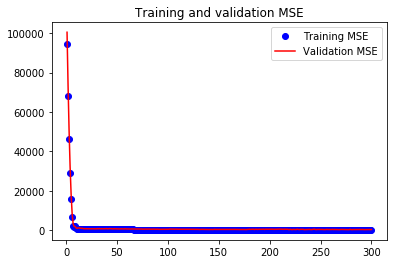

Average validation MSE:  387.09643682260986


In [16]:
mse, val_mse = [], []

mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

avg_val_mse = np.mean(history.history['val_mean_squared_error'][290:])
print('Average validation MSE: ', avg_val_mse)

In [11]:
model.save('Baseline LSTM.h5')

In [8]:
# LSTM with dense layers

model = Sequential()

model.add(LSTM(256, batch_size = shift_param, input_shape=(train_X.shape[1], train_X.shape[2]), 
               return_sequences=True, stateful=True, recurrent_dropout=0.2))
model.add(LSTM(128, stateful=True, recurrent_dropout=0.2))
model.add(Dense(1024, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop',  metrics=['mse'])

In [9]:
history = model.fit(train_X, train_y, epochs=300, batch_size=shift_param, validation_data=(test_X, test_y), shuffle=False)

Train on 14785200 samples, validate on 2505270 samples
Epoch 1/300
14785200/14785200 [==============================] - 134s 9us/step - loss: 38.7158 - mean_squared_error: 3341.9298 - val_loss: 29.2715 - val_mean_squared_error: 1594.0264
Epoch 2/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 29.9805 - mean_squared_error: 1616.1173 - val_loss: 37.2392 - val_mean_squared_error: 2352.5921
Epoch 3/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 27.6933 - mean_squared_error: 1423.9760 - val_loss: 24.1557 - val_mean_squared_error: 1151.2687
Epoch 4/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 26.4672 - mean_squared_error: 1290.7085 - val_loss: 36.3220 - val_mean_squared_error: 2153.5109
Epoch 5/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 25.7601 - mean_squared_error: 1215.1453 - val_loss: 23.2312 - val_mean_squared_error: 1048.4150
Epoch 6/300
14785200/14785200 

14785200/14785200 [==============================] - 117s 8us/step - loss: 15.6765 - mean_squared_error: 448.7973 - val_loss: 13.2517 - val_mean_squared_error: 388.6432
Epoch 91/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 15.7452 - mean_squared_error: 455.9234 - val_loss: 20.7433 - val_mean_squared_error: 655.1427
Epoch 92/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 15.5993 - mean_squared_error: 444.7361 - val_loss: 13.6082 - val_mean_squared_error: 420.6533
Epoch 93/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 15.6856 - mean_squared_error: 453.2012 - val_loss: 20.4983 - val_mean_squared_error: 652.3506
Epoch 94/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 15.5343 - mean_squared_error: 441.0731 - val_loss: 20.9214 - val_mean_squared_error: 666.7088
Epoch 95/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 15.4791 - mean_

Epoch 135/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 14.5881 - mean_squared_error: 386.9304 - val_loss: 16.6249 - val_mean_squared_error: 453.9157
Epoch 136/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 14.4979 - mean_squared_error: 379.2884 - val_loss: 18.6425 - val_mean_squared_error: 540.4826
Epoch 137/300
14785200/14785200 [==============================] - 116s 8us/step - loss: 14.4852 - mean_squared_error: 377.9103 - val_loss: 11.7369 - val_mean_squared_error: 292.6219
Epoch 138/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 14.5024 - mean_squared_error: 382.3199 - val_loss: 15.6816 - val_mean_squared_error: 420.6085
Epoch 139/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 14.4695 - mean_squared_error: 378.2382 - val_loss: 12.1214 - val_mean_squared_error: 311.9905
Epoch 140/300
14785200/14785200 [==============================] - 116s 8us/step - lo

Epoch 180/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 13.7285 - mean_squared_error: 343.6131 - val_loss: 12.2495 - val_mean_squared_error: 302.4300
Epoch 181/300
14785200/14785200 [==============================] - 116s 8us/step - loss: 13.7741 - mean_squared_error: 348.2534 - val_loss: 21.4898 - val_mean_squared_error: 656.3427
Epoch 182/300
14785200/14785200 [==============================] - 116s 8us/step - loss: 13.6943 - mean_squared_error: 341.3799 - val_loss: 19.3276 - val_mean_squared_error: 558.6360
Epoch 183/300
14785200/14785200 [==============================] - 116s 8us/step - loss: 13.6598 - mean_squared_error: 339.9812 - val_loss: 14.1675 - val_mean_squared_error: 359.7998
Epoch 184/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 13.7182 - mean_squared_error: 344.3544 - val_loss: 12.1940 - val_mean_squared_error: 299.4384
Epoch 185/300
14785200/14785200 [==============================] - 116s 8us/step - lo

Epoch 225/300
14785200/14785200 [==============================] - 116s 8us/step - loss: 13.0866 - mean_squared_error: 309.0419 - val_loss: 15.9778 - val_mean_squared_error: 405.9209
Epoch 226/300
14785200/14785200 [==============================] - 116s 8us/step - loss: 13.0686 - mean_squared_error: 307.2696 - val_loss: 12.5054 - val_mean_squared_error: 291.3251
Epoch 227/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 13.0879 - mean_squared_error: 309.8993 - val_loss: 13.1965 - val_mean_squared_error: 313.4030
Epoch 228/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 13.0718 - mean_squared_error: 308.9028 - val_loss: 14.5082 - val_mean_squared_error: 356.1039
Epoch 229/300
14785200/14785200 [==============================] - 116s 8us/step - loss: 13.0529 - mean_squared_error: 306.9742 - val_loss: 20.9465 - val_mean_squared_error: 615.4687
Epoch 230/300
14785200/14785200 [==============================] - 116s 8us/step - lo

Epoch 270/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 12.7059 - mean_squared_error: 289.5821 - val_loss: 15.1650 - val_mean_squared_error: 394.6479
Epoch 271/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 12.7097 - mean_squared_error: 289.8398 - val_loss: 15.5397 - val_mean_squared_error: 404.3949
Epoch 272/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 12.6830 - mean_squared_error: 288.1133 - val_loss: 21.8370 - val_mean_squared_error: 656.8605
Epoch 273/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 12.6122 - mean_squared_error: 282.5985 - val_loss: 22.4462 - val_mean_squared_error: 683.3833
Epoch 274/300
14785200/14785200 [==============================] - 117s 8us/step - loss: 12.5981 - mean_squared_error: 281.4772 - val_loss: 15.9838 - val_mean_squared_error: 417.5810
Epoch 275/300
14785200/14785200 [==============================] - 117s 8us/step - lo

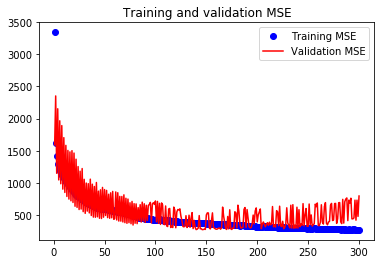

In [10]:
mse, val_mse = [], []

mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

In [11]:
model.save('LSTM.h5')

In [8]:
# LSTM with bidirectional layers

model = Sequential()

model.add(Bidirectional(LSTM(256, batch_size=shift_param, input_shape=(train_X.shape[1], train_X.shape[2]), 
               return_sequences=True, recurrent_dropout=0.2, stateful=True), 
                        batch_input_shape=(shift_param, train_X.shape[1], train_X.shape[2])))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.2, stateful=True)))
model.add(Dense(1024, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop',  metrics=['mse'])

In [9]:
history = model.fit(train_X, train_y, epochs=150, batch_size=shift_param, validation_data=(test_X, test_y), shuffle=False)

Train on 14785200 samples, validate on 2505270 samples
Epoch 1/150
14785200/14785200 [==============================] - 226s 15us/step - loss: 40.3400 - mean_squared_error: 3322.9646 - val_loss: 41.8119 - val_mean_squared_error: 2763.1928
Epoch 2/150
14785200/14785200 [==============================] - 200s 14us/step - loss: 30.7576 - mean_squared_error: 1607.3050 - val_loss: 27.2817 - val_mean_squared_error: 1339.1080
Epoch 3/150
14785200/14785200 [==============================] - 200s 14us/step - loss: 29.3116 - mean_squared_error: 1475.3130 - val_loss: 37.3315 - val_mean_squared_error: 2182.4041
Epoch 4/150
14785200/14785200 [==============================] - 200s 14us/step - loss: 28.0535 - mean_squared_error: 1366.9510 - val_loss: 24.9347 - val_mean_squared_error: 1190.8552
Epoch 5/150
14785200/14785200 [==============================] - 200s 14us/step - loss: 27.3425 - mean_squared_error: 1316.7603 - val_loss: 35.2242 - val_mean_squared_error: 1992.2729
Epoch 6/150
14785200/1478

Epoch 90/150
14785200/14785200 [==============================] - 199s 13us/step - loss: 15.6688 - mean_squared_error: 430.8665 - val_loss: 18.5265 - val_mean_squared_error: 790.4949
Epoch 91/150
14785200/14785200 [==============================] - 200s 13us/step - loss: 15.7843 - mean_squared_error: 439.4898 - val_loss: 25.2049 - val_mean_squared_error: 1037.7959
Epoch 92/150
14785200/14785200 [==============================] - 200s 14us/step - loss: 15.6180 - mean_squared_error: 427.8318 - val_loss: 18.7579 - val_mean_squared_error: 819.0519
Epoch 93/150
14785200/14785200 [==============================] - 200s 13us/step - loss: 15.8572 - mean_squared_error: 443.4139 - val_loss: 24.4363 - val_mean_squared_error: 992.9417
Epoch 94/150
14785200/14785200 [==============================] - 200s 13us/step - loss: 15.6132 - mean_squared_error: 427.7481 - val_loss: 18.5235 - val_mean_squared_error: 796.9002
Epoch 95/150
14785200/14785200 [==============================] - 199s 13us/step - l

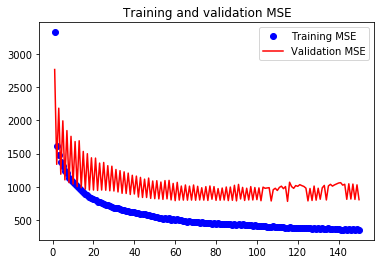

Average validation MSE:  1030.7481793179536


In [10]:
mse, val_mse = [], []

mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

avg_val_mse = np.mean(history.history['val_mean_squared_error'])
print('Average validation MSE: ', avg_val_mse)

In [12]:
# LSTM with batch normalization and bidirectional layers

model = Sequential()

model.add(BatchNormalization(batch_input_shape=(shift_param, train_X.shape[1], train_X.shape[2])))
model.add(Bidirectional(LSTM(256, batch_size=shift_param, input_shape=(train_X.shape[1], train_X.shape[2]), 
               return_sequences=True, recurrent_dropout=0.2, stateful=True)))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.2, stateful=True)))
model.add(Dense(1024, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='rmsprop',  metrics=['mse'])

In [13]:
history = model.fit(train_X, train_y, epochs=100, batch_size=shift_param, validation_data=(test_X, test_y), shuffle=False)

Train on 14785200 samples, validate on 2505270 samples
Epoch 1/100
14785200/14785200 [==============================] - 230s 16us/step - loss: 37.0189 - mean_squared_error: 3441.1722 - val_loss: 57.1417 - val_mean_squared_error: 4234.5182
Epoch 2/100
14785200/14785200 [==============================] - 206s 14us/step - loss: 26.4238 - mean_squared_error: 1179.3122 - val_loss: 27.5329 - val_mean_squared_error: 1452.2820
Epoch 3/100
14785200/14785200 [==============================] - 206s 14us/step - loss: 24.2393 - mean_squared_error: 993.7589 - val_loss: 42.5467 - val_mean_squared_error: 2861.0139
Epoch 4/100
14785200/14785200 [==============================] - 206s 14us/step - loss: 22.6477 - mean_squared_error: 863.0396 - val_loss: 28.9423 - val_mean_squared_error: 1525.1570
Epoch 5/100
14785200/14785200 [==============================] - 207s 14us/step - loss: 21.7373 - mean_squared_error: 794.4589 - val_loss: 39.5074 - val_mean_squared_error: 2478.5276
Epoch 6/100
14785200/1478520

14785200/14785200 [==============================] - 207s 14us/step - loss: 10.7137 - mean_squared_error: 193.6375 - val_loss: 74.5984 - val_mean_squared_error: 7363.4648
Epoch 90/100
14785200/14785200 [==============================] - 207s 14us/step - loss: 10.7368 - mean_squared_error: 194.8560 - val_loss: 82.1039 - val_mean_squared_error: 8662.6153
Epoch 91/100
14785200/14785200 [==============================] - 206s 14us/step - loss: 10.6496 - mean_squared_error: 189.0128 - val_loss: 82.0059 - val_mean_squared_error: 8635.9832
Epoch 92/100
14785200/14785200 [==============================] - 206s 14us/step - loss: 10.6477 - mean_squared_error: 189.4327 - val_loss: 76.2829 - val_mean_squared_error: 7715.8959
Epoch 93/100
14785200/14785200 [==============================] - 206s 14us/step - loss: 10.6514 - mean_squared_error: 191.5836 - val_loss: 82.6295 - val_mean_squared_error: 8653.6364
Epoch 94/100
14785200/14785200 [==============================] - 206s 14us/step - loss: 10.5

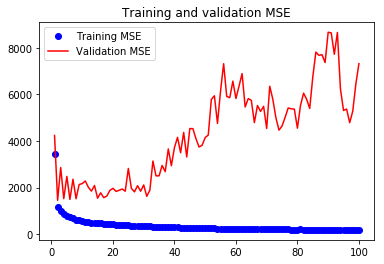

Average validation MSE:  4292.979835195071


In [17]:
mse, val_mse = [], []

mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

avg_val_mse = np.mean(history.history['val_mean_squared_error'])
print('Average validation MSE: ', avg_val_mse)